In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

After importing our libraries, we read the CSV file containing information about solar power generated (MW) every 5 minutes for 2006. We split the date and time information into new columns to aggregate the total amount of energy generated per day later.

In [2]:
df = pd.read_csv('/content/Actual_40.85_-73.85_2006_DPV_21MW_5_Min.csv')

df['LocalTime'] = pd.to_datetime(df['LocalTime'])
df['Date'] = df['LocalTime'].dt.date
df['Time'] = df['LocalTime'].dt.time

print(df.head())

<ipython-input-2-c82ac554ffdd>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['LocalTime'] = pd.to_datetime(df['LocalTime'])


            LocalTime  Power(MW)        Date      Time
0 2006-01-01 00:00:00        0.0  2006-01-01  00:00:00
1 2006-01-01 00:05:00        0.0  2006-01-01  00:05:00
2 2006-01-01 00:10:00        0.0  2006-01-01  00:10:00
3 2006-01-01 00:15:00        0.0  2006-01-01  00:15:00
4 2006-01-01 00:20:00        0.0  2006-01-01  00:20:00


As shown in the preview, no power was generated around midnight on January 1, but we won't need a 5-minute resolution for this analysis. We'll want to take the sum of MW generated over each full day in the year so we can later assign that total value as the dependent variable. We'll then correlate it to multiple independent variables and local weather features from a separate dataset.

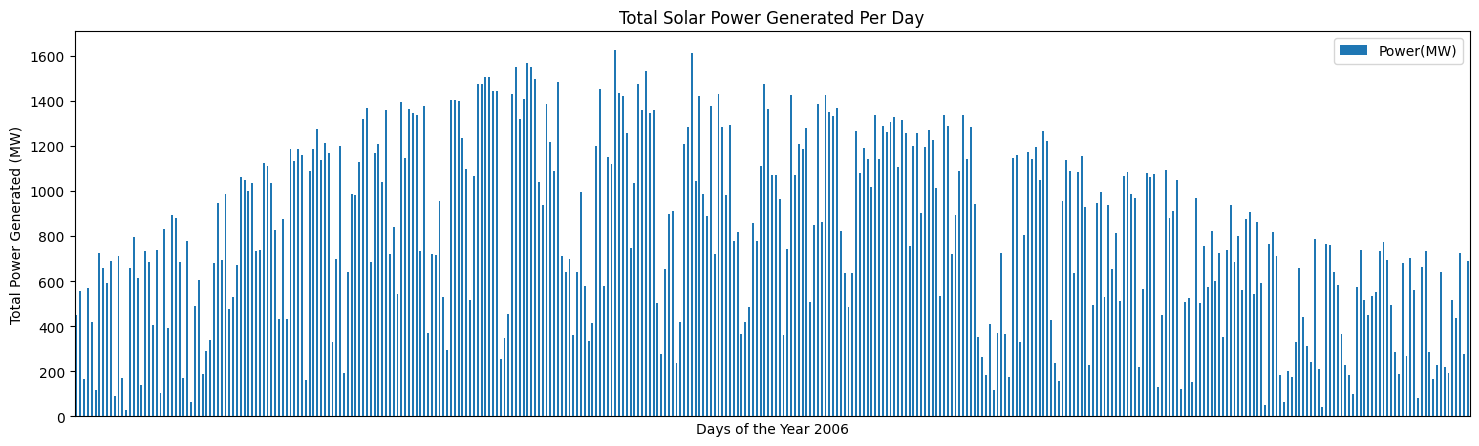

In [3]:
days_df = df.groupby('Date').sum('Power(MW)').reset_index()
days_df.plot(kind='bar', x='Date', y='Power(MW)', xlabel='Days of the Year 2006', ylabel='Total Power Generated (MW)')

plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().set_title('Total Solar Power Generated Per Day')
plt.gcf().set_size_inches(18, 5)

Above, we can see a bell curve distribution among the high values, peaking in the summer months, with plenty of much lower days interspersed. To create a predictive model for total power generated per day, let's load up a separate CSV file containing key weather features for the corresponding time and place: 2006 in The Bronx, NY.

In [4]:
features_df = pd.read_csv('/content/Bronx_Weather_2006.csv', header=0)

print(features_df.head())

         Date  TempF       TempK  Humidity  HrsDaylight
0  2006-01-01   37.7  276.316667      75.2         9.00
1  2006-01-02   42.2  278.816667      73.7         9.04
2  2006-01-03   37.9  276.427778      85.2         9.08
3  2006-01-04   34.3  274.427778      70.4         9.12
4  2006-01-05   42.5  278.983333      76.5         9.16


Before completing the linear regression, let's plot these three weather features throughout 2006 to see how they vary over the year.



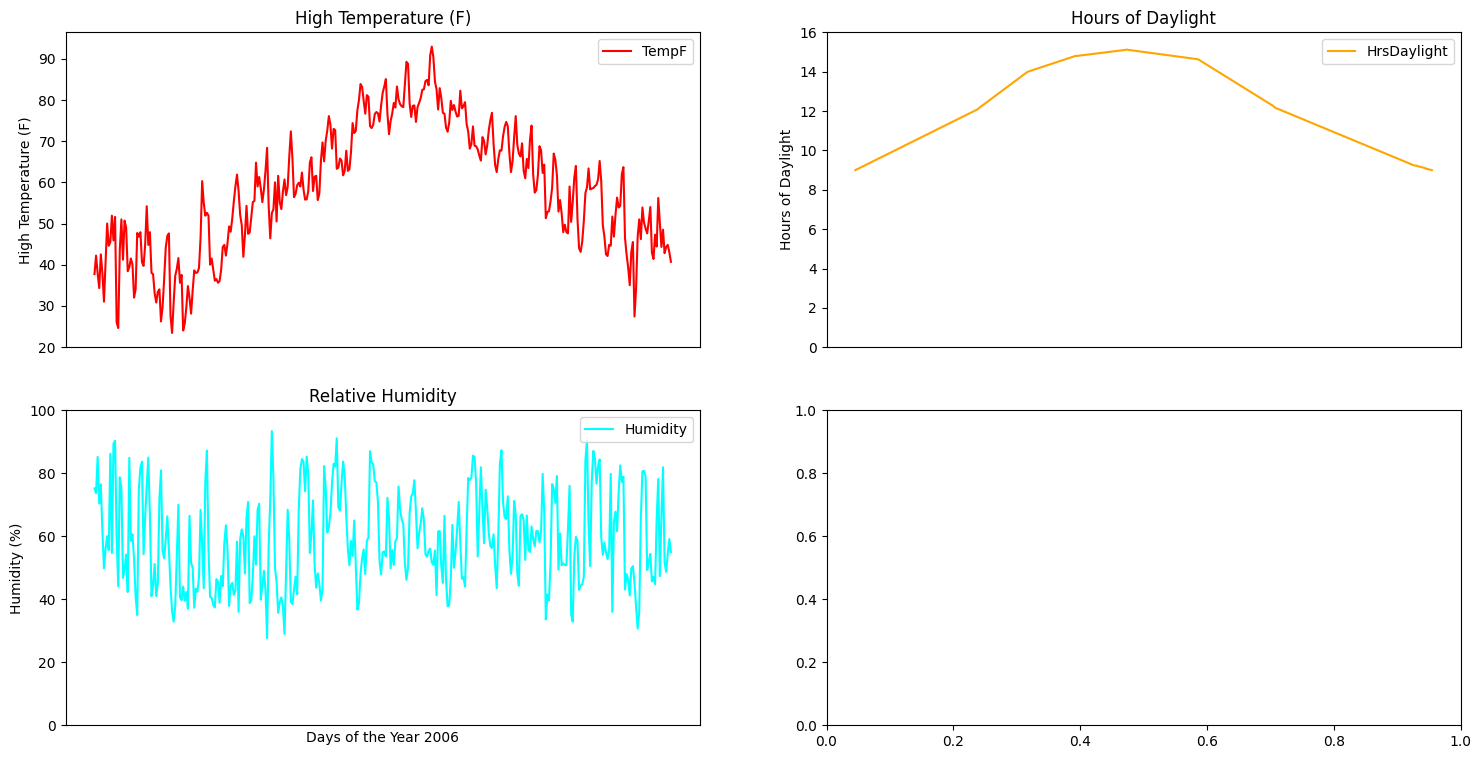

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 9))

features_df.plot(kind='line', x='Date', y='TempF', ax=axs[0, 0], color='red')
axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('High Temperature (F)')
axs[0, 0].set_title('High Temperature (F)')
axs[0, 0].xaxis.set_major_locator(plt.NullLocator())

features_df.plot(kind='line', x='Date', y='HrsDaylight', ax=axs[0, 1], color='orange')
axs[0, 1].set_xlabel('')
axs[0, 1].set_ylabel('Hours of Daylight')
axs[0, 1].set_title('Hours of Daylight')
axs[0, 1].set_ylim(0, 16)
axs[0, 1].xaxis.set_major_locator(plt.NullLocator())

features_df.plot(kind='line', x='Date', y='Humidity', ax=axs[1, 0], color='cyan')
axs[1, 0].set_xlabel('Days of the Year 2006')
axs[1, 0].set_ylabel('Humidity (%)')
axs[1, 0].set_title('Relative Humidity')
axs[1, 0].set_ylim(0, 100)
axs[1, 0].legend(loc='upper right')
axs[1, 0].xaxis.set_major_locator(plt.NullLocator())



We want to correlate our target variable (solar power generated) to our weather features, so let's merge these two data frames on Date. Even though TempF (high temperature perature in Fahrenheit) is not measured in an absolute unit like degrees Kelvin, linear regression is agnostic to scale and offset - I even tried converting to Kelvin with the same results!

In [8]:
merge_df = days_df.merge(features_df,
                  on ='Date', how='right')
merge_df['Power(MW)'] = days_df['Power(MW)']

print(merge_df.head())

         Date  Power(MW)  TempF       TempK  Humidity  HrsDaylight
0  2006-01-01      451.3   37.7  276.316667      75.2         9.00
1  2006-01-02      557.7   42.2  278.816667      73.7         9.04
2  2006-01-03      164.7   37.9  276.427778      85.2         9.08
3  2006-01-04      567.5   34.3  274.427778      70.4         9.12
4  2006-01-05      418.6   42.5  278.983333      76.5         9.16


Let's train and analyze a linear regression model before considering polynomial relationships. We'll set the independent variables (X) as every column except Date and Power(MW) and set the dependent variable (y) as the column Power(MW) only. We can separate a test set from most training data to run predictions on later.

In [9]:
X = merge_df.drop('Power(MW)',axis=1)
X = X.drop('Date',axis=1)
y = merge_df['Power(MW)'].to_numpy().reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=40)

model = LinearRegression()
model.fit(X_train, y_train)

coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(model.coef_))], axis=1, ignore_index=True)
coefficients.rename(columns={0: 'Feature', 1: 'Coefficient'}, inplace=True)

print(coefficients)

       Feature   Coefficient
0        TempF  6.082308e+06
1        TempK -1.094815e+07
2     Humidity -1.655857e+01
3  HrsDaylight  1.016962e+02


These coefficients shed light on each feature's impact on solar power generated. The positive values for TempF (high temperature in Fahrenheit) and HrsDaylight indicate a positive correlation, while Humidity and Precipitation are negatively correlated. Now that the linear regression model is trained, we can run predictions on the test set based on the weather conditions and then compare these predictions to the known, actual values in terms of Difference and % Error.

In [10]:
predictions = model.predict(X_test)

predict_df = pd.DataFrame(y_test)
predict_df.columns = ['ActualValue(MW)']

predict_df['PredValue(MW)'] = predictions
predict_df['PredValue(MW)'] = predict_df['PredValue(MW)'].apply(lambda value:round(value, 1))

predict_df['Difference'] = predictions - y_test
predict_df['Difference'] = predict_df['Difference'].apply(lambda value:round(value, 1))

predict_df['% Error'] = round(100*(predict_df['Difference']/predict_df['ActualValue(MW)']), 2)

print(predict_df)
print('\n')
print('Mean Difference:')
print(round(predict_df['Difference'].sum()/36, 1))
print('\n')
print('Mean Squared Difference')
print(round(predict_df['Difference'].apply(lambda value:value**2).sum()/36, 1))

    ActualValue(MW)  PredValue(MW)  Difference  % Error
0            1286.4         1066.1      -220.3   -17.13
1             881.9         1007.7       125.8    14.26
2             812.3          881.2        68.9     8.48
3             994.3          634.3      -360.0   -36.21
4             494.2          676.7       182.5    36.93
5             689.9          552.9      -137.0   -19.86
6             367.5          641.4       273.9    74.53
7            1198.4         1006.5      -191.9   -16.01
8             860.4          834.1       -26.3    -3.06
9            1435.2         1296.3      -138.9    -9.68
10           1186.6          851.8      -334.8   -28.22
11           1185.0         1101.5       -83.5    -7.05
12           1186.9          916.9      -270.0   -22.75
13            185.5          159.7       -25.8   -13.91
14            786.8          682.4      -104.4   -13.27
15            116.0          500.7       384.7   331.64
16            567.5          273.8      -293.7  

The negative mean difference value observed indicates that this linear regression model tends to underestimate the amount of solar power generated overall. The Mean Squared Difference provides a metric for evaluating the total error.

Let's merge the Date column back into our predictions to visualize the model's test data performance. Not bad at all, considering these predictions are exclusively based on weather data and a linear regression model!

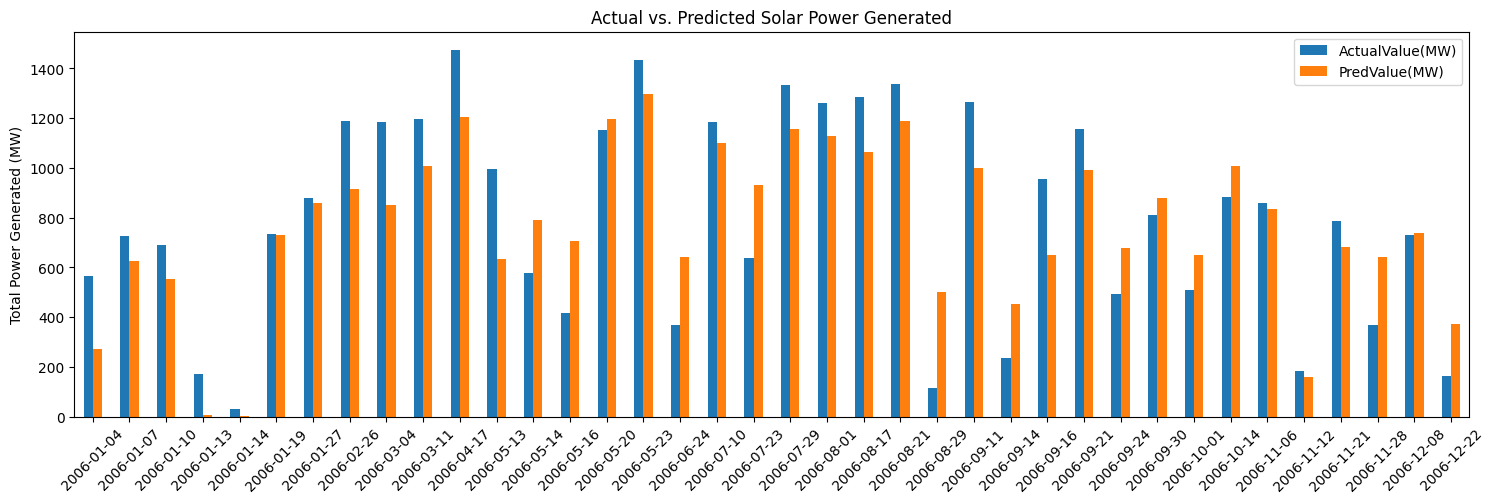

In [11]:
merge_test_df = predict_df.merge(merge_df,
                  left_on='ActualValue(MW)', right_on='Power(MW)', how='left')
merge_test_df.sort_values(by=['Date'], inplace=True)
merge_test_df = merge_test_df.reset_index(drop=True)

merge_test_df.plot(x='Date', y=['ActualValue(MW)', 'PredValue(MW)'], xlabel='', ylabel='Total Power Generated (MW)', kind="bar", rot=45)
plt.gca().set_title('Actual vs. Predicted Solar Power Generated')
plt.gcf().set_size_inches(18, 5)

Seen visually, the trend in bias is more evident: predictions often err toward the middle. Dates with high solar power are susceptible to underestimating, while days with deficient solar power generated may be overestimated.

However, are all the weather features we included valuable to the model? Let's use a recursive feature elimination with cross-validation to tell us the optimal combination of weather features.

In [12]:
X = merge_df.drop('Power(MW)',axis=1)
X = X.drop('Date',axis=1)
y = merge_df['Power(MW)']

estimator = SVR(kernel='linear')
rfecv = RFECV(estimator, step=1, cv=5)
rfecv.fit(X, y)

features = list(X.columns[rfecv.support_])
print('Optimal number of features: ', rfecv.n_features_)
print(features)

Optimal number of features:  2
['Humidity', 'HrsDaylight']


Sure enough, the TempF feature is absent and not recommended. Let's drop it entirely and then evaluate the same training and testing procedure.

In [16]:
X_2 = X.drop('TempF',axis=1)
y_2 = merge_df['Power(MW)']

X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(
    X_2, y_2, test_size=0.1, random_state=40)

model_2 = LinearRegression()
model_2.fit(X_2_train, y_2_train)

coefficients_2 = pd.concat([pd.DataFrame(X_2.columns),pd.DataFrame(np.transpose(model_2.coef_))], axis=1, ignore_index=True)
coefficients_2.rename(columns={0: 'Feature', 1: 'Coefficient'}, inplace=True)

print(coefficients_2)

       Feature  Coefficient
0        TempK     1.637553
1     Humidity   -16.559815
2  HrsDaylight   101.688731


In [17]:
predictions_2 = model_2.predict(X_2_test)

predict_df_2 = pd.DataFrame(y_2_test)
predict_df_2.columns = ['ActualValue(MW)']

predict_df_2['PredValue(MW)'] = predictions_2
predict_df_2['PredValue(MW)'] = predict_df_2['PredValue(MW)'].apply(lambda value:round(value, 1))

predict_df_2['Difference'] = predictions_2 - y_2_test
predict_df_2['Difference'] = predict_df_2['Difference'].apply(lambda value:round(value, 1))

predict_df_2['% Error'] = round(100*(predict_df_2['Difference']/predict_df_2['ActualValue(MW)']), 2)

print('Mean Difference:')
print(round(predict_df_2['Difference'].sum()/36, 1))
print('\n')
print('Mean Squared Difference')
print(round(predict_df_2['Difference'].apply(lambda value:value**2).sum()/36, 1))

Mean Difference:
-42.2


Mean Squared Difference
42314.9


After removing the TempF feature, the Mean Difference and Mean Squared Difference are virtually unchanged (as would be the plot). Since the feature doesn't seem to be adding predictive value, we'll remove it and streamline the model.

However, what if the relationship between the weather variables and the solar power generated is not linear at all, but quadriatic? Let's compare the model's performance after creating a pipeline where we use "polynomial features" with degree 2. This will synthesize new features by squaring each of Our weather variables and multiplying each of them by each other. (With a higher degree, like 3 or 4, the possible combinations would grow but risk overfitting the training data.)

In [18]:
X_3 = X_2
y_3 = merge_df['Power(MW)']

X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(
    X_3, y_3, test_size=0.1, random_state=40)

model_3 = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(), LinearRegression())
model_3.fit(X_3_train, y_3_train)

predictions_3 = model_3.predict(X_3_test)

predict_df_3 = pd.DataFrame(y_3_test)
predict_df_3.columns = ['ActualValue(MW)']
predict_df_3.reset_index()

predict_df_3['PredValue(MW)'] = predictions_3
predict_df_3['PredValue(MW)'] = predict_df_3['PredValue(MW)'].apply(lambda value:round(value, 1))

predict_df_3['Difference'] = predictions_3 - y_3_test
predict_df_3['Difference'] = predict_df_3['Difference'].apply(lambda value:round(value, 1))

predict_df_3['% Error'] = round(100*(predict_df_3['Difference']/predict_df_3['ActualValue(MW)']), 2)

print(predict_df_3)
print('\n')
print('Mean Difference:')
print(round(predict_df_3['Difference'].sum()/36, 1))
print('\n')
print('Mean Squared Difference')
print(round(predict_df_3['Difference'].apply(lambda value:value**2).sum()/36, 1))

     ActualValue(MW)  PredValue(MW)  Difference  % Error
228           1286.4         1094.3      -192.1   -14.93
286            881.9          921.4        39.5     4.48
272            812.3          861.9        49.6     6.11
132            994.3          448.7      -545.6   -54.87
266            494.2          755.8       261.6    52.93
9              689.9          523.3      -166.6   -24.15
174            367.5          445.8        78.3    21.31
69            1198.4          941.3      -257.1   -21.45
309            860.4          763.5       -96.9   -11.26
142           1435.2         1387.8       -47.4    -3.30
62            1186.6          937.9      -248.7   -20.96
190           1185.0         1131.7       -53.3    -4.50
56            1186.9         1081.7      -105.2    -8.86
315            185.5          210.6        25.1    13.53
324            786.8          664.9      -121.9   -15.49
240            116.0          412.6       296.6   255.69
3              567.5          3

Wow, introducing polynomial features decreased the Mean Squared Difference from 36561.5 to 26534.8, a drop of 27.4%! Let's plot these improved predictions.

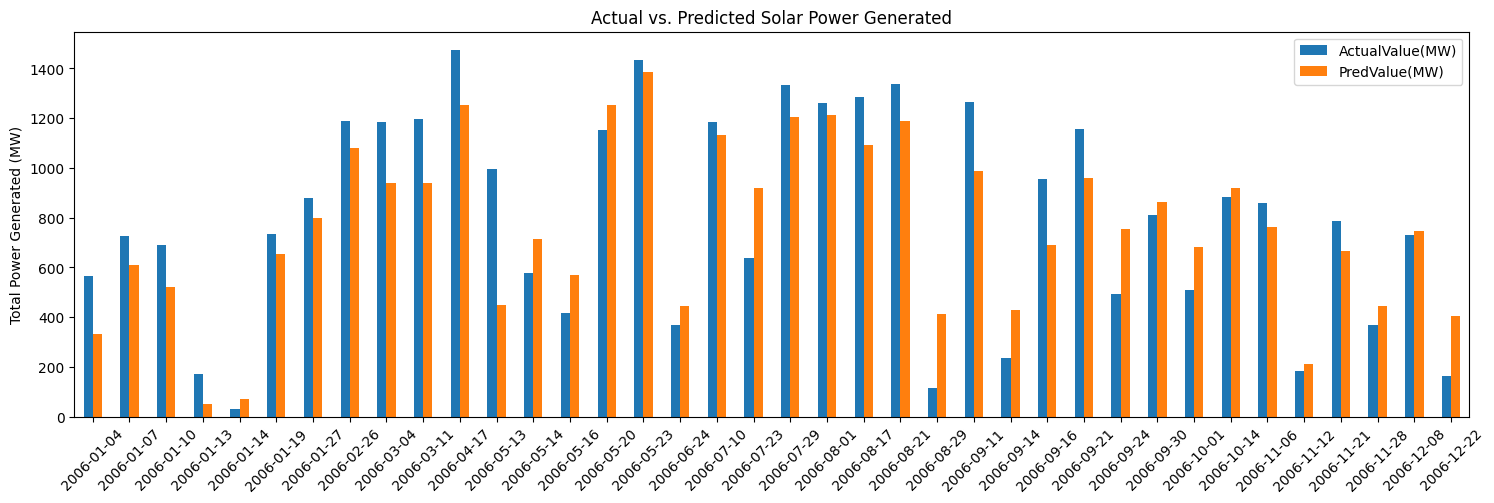

In [19]:
merge_test_df_3 = predict_df_3.merge(merge_df,
                  left_on='ActualValue(MW)', right_on='Power(MW)', how='left')
merge_test_df_3.sort_values(by=['Date'], inplace=True)
merge_test_df_3 = merge_test_df_3.reset_index(drop=True)

merge_test_df_3.plot(x='Date', y=['ActualValue(MW)', 'PredValue(MW)'], xlabel='', ylabel='Total Power Generated (MW)', kind="bar", rot=45)
plt.gca().set_title('Actual vs. Predicted Solar Power Generated')
plt.gcf().set_size_inches(18, 5)